# Getting Started: Time Series Normalization (Chaining Pairwise Calibrations)

This notebook demonstrates usage of the `Harmonizer` class, which
aligns multiple sensors onto one target sensor's scale by chaining
local calibrations in a left pass and a right pass.

## Overview
- **Linear mode**: Simple slope-intercept composition for multiple sensors.
- **Seasonal mode**: (Optional) seasonal decomposition for exactly two sensors.

We will:
1. Import the `Harmonizer` class from your library.
2. Create or simulate example sensor data.
3. Use `Harmonizer(method='linear')` to align multiple sensors.
4. Use `Harmonizer(method='seasonal_decompose')` for two sensors with seasonality.

In [1]:
import numpy as np

from pixltsnorm import Harmonizer

## 2. Example Data

### 2.1 Multiple Sensors (Linear)
We'll simulate 3 sensors, with sensor2 as the "true" or final scale:
- sensor0 has slope=1.1 and intercept=+2 relative to sensor2
- sensor1 has slope=0.9 and intercept=-1.5 relative to sensor2
- sensor2 is the target (no offset).

In [2]:
n_points = 10
true_scale = np.linspace(0, 20, n_points)  # e.g., the "true" or "target" scale

sensor0 = 1.1 * true_scale + 2.0   # offset from true_scale
sensor1 = 0.9 * true_scale - 1.5
sensor2 = true_scale               # target

possible_jumps = np.arange(0.1, 1.01, 0.1)

noise0 = np.random.choice(possible_jumps, size=n_points, replace=True)
noise1 = np.random.choice(possible_jumps, size=n_points, replace=True)
noise2 = np.random.choice(possible_jumps, size=n_points, replace=True)

sensor0 += noise0
sensor1 += noise1
sensor2 += noise2

sensor_list_linear = [sensor0, sensor1, sensor2]

### 2.2 Two Sensors (Seasonal)
We'll create a short sinusoidal pattern with some random noise and assume
sensor B is the target scale. We'll also provide a `time_idx` to match each data point.


In [3]:
time_idx = np.arange(48)
sensorA_seasonal = 5 + 2 * np.sin(2 * np.pi * time_idx / 12) + np.random.randn(48) * 0.2
sensorB_seasonal = sensorA_seasonal * 1.2 + 3.0

possible_jumps = np.arange(0.2, 2.01, 0.2)
random_jumps = np.random.choice(possible_jumps, size=48, replace=True)

sensorB_seasonal += random_jumps  # each point gets an extra small discrete offset

sensor_list_seasonal = [sensorA_seasonal, sensorB_seasonal]
time_list_seasonal = [time_idx, time_idx]  # for 2 sensors, same time index

## 3. Harmonizing Multiple Sensors (Linear)

We'll instantiate `Harmonizer(method='linear')`, fit on the 3-sensor list,
and then see the resulting transforms. By default, the last sensor (index=2)
is used as the target.

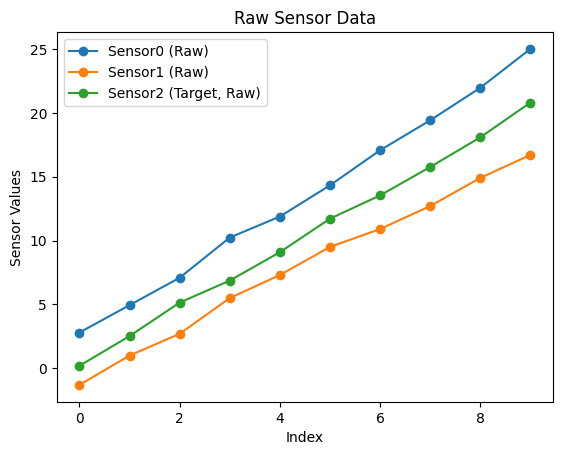

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sensor0, marker='o', label='Sensor0 (Raw)')
plt.plot(sensor1, marker='o', label='Sensor1 (Raw)')
plt.plot(sensor2, marker='o', label='Sensor2 (Target, Raw)')
plt.xlabel('Index')
plt.ylabel('Sensor Values')
plt.title('Raw Sensor Data')
plt.legend()
plt.show()

In [5]:
harm_lin = Harmonizer(method='linear', outlier_threshold=5.0)
harm_lin.fit(sensor_list_linear)  # sensor2 is target by default

print("Pairwise Left:", harm_lin.pairwise_left_)
print("Pairwise Right:", harm_lin.pairwise_right_)
print("\nFinal transforms (sensor_i -> sensor2):")
for i, (slope, intercept) in enumerate(harm_lin.transforms_):
    print(f" Sensor {i}: slope={slope:.3f}, intercept={intercept:.3f}")

# Example transformation for a new reading from sensor0
new_x0 = 10.0
mapped0 = harm_lin.transform(sensor_index=0, x=new_x0)
print(f"\nSensor0 reading {new_x0} -> sensor2 scale => {mapped0:.3f}")

Pairwise Left: [((1, 2), (np.float64(1.125376831473305), np.float64(1.3782391165282935))), ((0, 1), (np.float64(0.9269092932089582), np.float64(-3.803258294196545)))]
Pairwise Right: []

Final transforms (sensor_i -> sensor2):
 Sensor 0: slope=1.043, intercept=-2.526
 Sensor 1: slope=1.125, intercept=1.378
 Sensor 2: slope=1.000, intercept=0.000

Sensor0 reading 10.0 -> sensor2 scale => 7.905


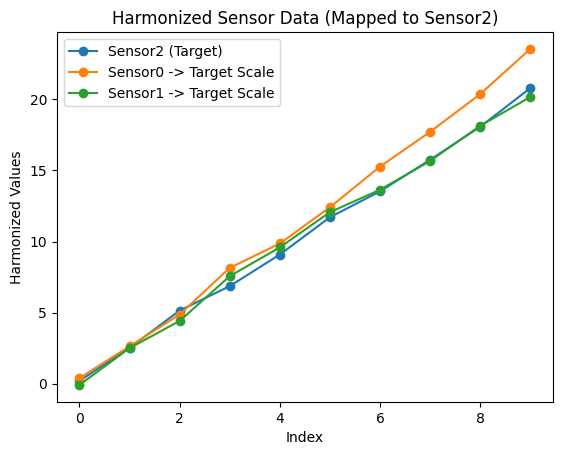

In [6]:
harmonized0 = [harm_lin.transform(0, x) for x in sensor0]
harmonized1 = [harm_lin.transform(1, x) for x in sensor1]

plt.figure()
plt.plot(sensor2, marker='o', label='Sensor2 (Target)')
plt.plot(harmonized0, marker='o', label='Sensor0 -> Target Scale')
plt.plot(harmonized1, marker='o', label='Sensor1 -> Target Scale')
plt.xlabel('Index')
plt.ylabel('Harmonized Values')
plt.title('Harmonized Sensor Data (Mapped to Sensor2)')
plt.legend()
plt.show()

## 4. Harmonizing Two Sensors (Seasonal Decompose)

Now we'll demonstrate `method='seasonal_decompose'` with exactly 2 sensors.
We'll treat sensorB_seasonal (index=1) as the target by default.

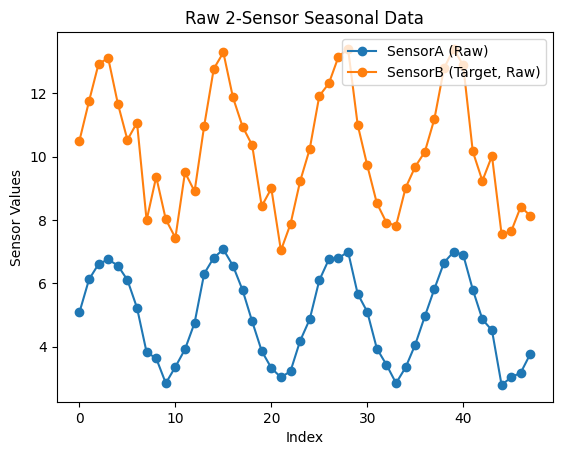

In [7]:
plt.figure()
plt.plot(sensorA_seasonal, marker='o', label='SensorA (Raw)')
plt.plot(sensorB_seasonal, marker='o', label='SensorB (Target, Raw)')
plt.xlabel('Index')
plt.ylabel('Sensor Values')
plt.title('Raw 2-Sensor Seasonal Data')
plt.legend()
plt.show()

In [8]:
harm_seas = Harmonizer(method='seasonal_decompose', period=12, outlier_threshold=10.0)

# Fit the 2-sensor list, providing time indexes for alignment
harm_seas.fit(sensor_list_seasonal, time_indexes=time_list_seasonal)

print("Pairwise Left:", harm_seas.pairwise_left_)
print("Pairwise Right:", harm_seas.pairwise_right_)

# Transform a new reading from sensorA at time=5
xA = sensorA_seasonal[5]
tA = 5
mappedA = harm_seas.transform(sensor_index=0, x=xA, t=tA)
print(f"\nAt time t={tA}, sensorA value={xA:.3f} => {mappedA:.3f} on sensorB scale.")

Pairwise Left: [((0, 1), (np.float64(1.7553205806059555), np.float64(1.4845451799226854)))]
Pairwise Right: []

At time t=5, sensorA value=6.107 => 11.144 on sensorB scale.


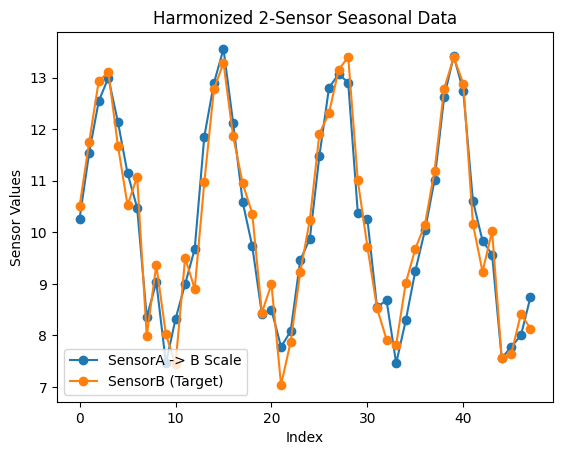

In [9]:
harmonizedA = [harm_seas.transform(sensor_index=0, x=val, t=i) 
               for i, val in enumerate(sensorA_seasonal)]

plt.figure()
plt.plot(harmonizedA, marker='o', label='SensorA -> B Scale')
plt.plot(sensorB_seasonal, marker='o', label='SensorB (Target)')
plt.xlabel('Index')
plt.ylabel('Sensor Values')
plt.title('Harmonized 2-Sensor Seasonal Data')
plt.legend()
plt.show()

# Done!
You have now:
- Imported the Harmonizer class from your package.
- Created some synthetic data for multiple sensors (linear).
- Created seasonal data for a 2-sensor scenario.
- Demonstrated how to use the Harmonizer for both cases.